# Simulation for Potts model
- All levels of interaction
- Field (constant for each point)
- Preference for low number of colors
- Distance between different colors (0 if equal, 1 of different)

- $N$ vertices
- $P(\sigma) = \frac{1}{N^N} \exp((N-n(\sigma))\gamma$), where $n(\sigma) = \text{# of colors used in } \sigma$

- Consider the interaction on the largest hyperedge on lattice $\Lambda$, where $|\Lambda| = N$
- We assign $\eta_{\Lambda} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with $\{1,2,...,N\}$ (a set with $k$ colors corresponds to $k$).
- Each of these corresponds to an energy level in $\{(N-1)\gamma, (N-2)\gamma, ..., 0\}$


- Consider the interaction between adjacent sites (edges) $b$ with size $|b|=2$
- To each edge assign $\eta_{b} \in \mathcal{P}(\{0,1\}^2)$ which is in one-to-one correspondence with the edge being open or closed.
- Each of these corresponds to an energy level in $\{J, -J\}$

- Consider the interaction between adjacent sites and the field, corresponding to $v$ with size $|v|=1$
- To each site assign $\eta_{v} \in \mathcal{P}(\{1,2,...,q\}^N)$ which is in one-to-one correspondence with the color of the site.
- Each of these corresponds to an energy level in $\{(N-1)\alpha, (N-2)\alpha, ...,(N-k)\alpha, ...,0\}$ where $k$ corresponds to the $k$th preferred color of the field.

- Take $ \upsilon_k =  \frac{e^{((N-k)\gamma)} - e^{((N-k-1)\gamma)}}{e^{((N-1)\gamma)}} $

- Joint distribution
- $Q(\eta, \sigma) = \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} $

- Marginals
- $Q(\eta | \sigma) =  \frac { \upsilon_{\eta_{\Lambda}} \frac{1}{N^N} \mathbb{1}_{(n(\sigma) \leq \eta_{\Lambda})} }{P(\sigma)}$
- $Q(\sigma | \eta) = \frac{1}{|\{\sigma:  \eta(\sigma) \leq \eta(\Lambda)\}|} $

In [150]:
# Initial code from https://rajeshrinet.github.io/blog/2014/ising-model/

import numpy as np 
from numpy.random import rand
from scipy.special import binom
from unionfind import UnionFind

# Implement Union Find to find clusters in the configurations
# https://github.com/deehzee/unionfind/blob/master/unionfind.py

# Toggle printing for debugging
prt = True

def initial_config(N, no_colors=2):   
    ''' Generate a random color/spin configuration for initialization'''
    state = np.random.randint(low=1, high=no_colors+1, size=(N,N))
    return state


def mc_move(config, eta_prob, eta, N, no_colors, sites):
    '''Monte Carlo move using generalized SW algorithm '''
    # Assign eta to each hyperedge
    eta = assign_etas(config, eta_prob, eta, no_colors)
    # Assign labels to each site
    config = assign_labels(config, eta, N, no_colors, sites)
    if prt: print('config:')
    if prt: print(config)
    return config


def number_of_colors (config):
    '''Number of colors used in the given confuration of labels'''
    return len(np.unique(config))


def avg_sites_per_color (config):
    '''Average number of sites each present color has in the configuration'''
    unq = np.unique(config)
    return config.shape[0]*config.shape[1]/len(unq)


def prob_eta_lambda(gamma, no_colors, k):
    '''Probability of the eta lambda corresponding to a certain number of colors'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*gamma) - np.exp((no_colors-k-1)*gamma) ) / np.exp((no_colors-1)*gamma)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*gamma)
    
    
def prob_eta_edge(J, col1, col2):
    '''Probability of the eta edge corresponding to open or not'''
    if col1==col2:
        return 1 - np.exp(-2*J)
    else:
        return np.exp(-2*J)
    
    
def prob_eta_site(alpha, no_colors, k):
    '''Probability of the eta site corresponding to a maximum color number (lower have higher energy)'''
    if k < no_colors:
        return ( np.exp((no_colors-k)*alpha) - np.exp((no_colors-k-1)*alpha) ) / np.exp((no_colors-1)*alpha)
    elif k == no_colors:
        return 1 / np.exp((no_colors-1)*alpha)

    
def assign_etas(config, eta_prob, eta, no_colors):
    
    '''Assign a number of colors that is at least the current number of colors'''
    eta_lambda = eta[0]
    prob_lambda = eta_prob[0]
    if prt: print('probabilities for no. of colors (lambda):', prob_lambda)
    
    current_k = number_of_colors(config)
    p = prob_lambda[current_k-1:]
    if prt: print('current no. cols (lambda):', current_k)
    p = p / p.sum()
    eta_lambda = np.random.choice((np.arange(current_k, no_colors+1)), p=p)
    eta[0] = eta_lambda
    if prt: print('assigned no. cols (eta_lambda):', eta_lambda)

    '''Assign a closed or open bond to each edge'''
    eta_edges = eta[1]
    prob_edge = eta_prob[1]
    if prt: print('probabilities for edges:', prob_edge)
    
    # loop over edges
    for i in range(eta_edges.shape[0]):
        for j in range(eta_edges.shape[1]):
            for e in range(eta_edges.shape[2]):
                if eta_edges[i,j,e] == -1: continue
                if e==0: current_b = (0 if config[i,j]==config[i+1,j] else 1)          
                elif e==1: current_b = (0 if config[i,j]==config[i,j+1] else 1) 
                    
                p = prob_edge[current_b:]
                p = p / p.sum()
                eta_edge = np.random.choice((np.arange(current_b, 1+1)), p=p) # 0 for present bonds, 1 for not
                eta_edges[i,j,e] = eta_edge
    eta[1] = eta_edges
    if prt: print('assigned bonds (eta_edges):')
    if prt: print(eta_edges[:,:,0])
    if prt: print()
    if prt: print(eta_edges[:,:,1])
    
    '''Assign a color that has at most the current energy for the color (color number is at least the current one)'''
    eta_sites = eta[2]
    prob_site = eta_prob[2]
    if prt: print('probabilities for colors (sites):', prob_site)
    
    # loop over sites
    for i in range(eta_sites.shape[0]):
        for j in range(eta_sites.shape[1]):
            current_s = config[i,j]
            p = prob_site[current_s-1:]
            p = p / p.sum()
            # if prt: print('normalized:', p)
            eta_site = np.random.choice((np.arange(current_s, no_colors+1)), p=p)
            eta_sites[i,j] = eta_site
    eta[2] = eta_sites
    if prt: print('assigned max colors (eta_sites):')
    if prt: print(eta_sites)
    
    return eta


def site2str(tup):
    return str(tup[0]) + ',' + str(tup[1])

def str2site(strr):
    t = strr.split(',')
    return [int(x) for x in t]

def sample_config(config, eta, N, no_colors, sites, uf=None, comp_constraints=None):
    
    if uf==None:
        '''Generate clusters from the assigned bonds (eta_edge)'''
        uf = UnionFind(sites)
        eta_edges = eta[1]
        for i in range(eta_edges.shape[0]):
            for j in range(eta_edges.shape[1]):
                for e in range(eta_edges.shape[2]):
                    if eta_edges[i,j,e] == -1: continue
                    if eta_edges[i,j,e] == 0:
                        if e==0: uf.union(site2str((i,j)), site2str((i+1,j)))
                        elif e==1: uf.union(site2str((i,j)), site2str((i,j+1)))    

        '''For each cluster, find the site with strongest constraint (smallest eta_site)
           and assign that eta_site to the entire cluster
        '''
        eta_sites = eta[2]
        comp_constraints = {}
        cl_n = 0
        cls = np.zeros((eta_sites.shape[0],eta_sites.shape[1]), dtype=np.int8)
        for comp in uf.components():
            cl_n += 1
            min_constraint = no_colors
            comp_root = '-1,-1'
            for site_str in comp:
                site = str2site(site_str)
                if eta_sites[site[0],site[1]] <= min_constraint:
                    min_constraint = eta_sites[site[0],site[1]]
                    comp_root = site_str
                cls[site[0],site[1]] = cl_n
            comp_constraints[comp_root] = min_constraint
        if prt: print('clusters formed by bonds (eta_edge):')
        if prt: print(cls)
    
    '''Randomly sample a color for each cluster'''
    for root in comp_constraints:
        max_col = comp_constraints[root]
        comp_color = np.random.choice((np.arange(1, max_col+1)))
        for site_str in uf.component(root):
            site = str2site(site_str)
            config[site[0],site[1]] = comp_color
            
    return config, uf, comp_constraints

    
def assign_labels(config, eta, N, no_colors, sites):
    '''Assign a color configuration chosen uniformly from the configurations compatible with eta'''
    # Brute force version
    max_colors = eta[0] # eta_lambda
    config, uf, comp_constraints = sample_config(config, eta, N, no_colors, sites)
    while number_of_colors(config) > max_colors:
        config, uf, comp_constraints = sample_config(config, eta, N, no_colors, sites, uf, comp_constraints)
        if prt: print('retrying sample (too many colors)')
    return config

## Experiment routine

In [151]:
# Small experiment

N, no_cols = 8, 6
gamma = 1    # strength of preference for low no. of cols
J = 0.5      # strength of preference for bonds
alpha = 0.2  # strength of preference for colors (field)

'''Probabilities ordered from highest (high energy) to lowest'''
lambda_prob = np.zeros(no_cols)
for j in range(no_cols):
    lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
print('lambda probabilities:', lambda_prob)

edge_prob = np.zeros(2)
edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
print('edge probabilities:', edge_prob)

site_prob = np.zeros(no_cols)
for j in range(no_cols):
    site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
print('site probabilities:', site_prob)

eta_prob = (lambda_prob, edge_prob, site_prob)

'''Current states of eta'''
eta_lambda = 0
eta_edges = np.zeros((N,N,2), dtype=np.int8)
# Special edge cases (no neighbors at the border)
eta_edges[:,N-1,1] = -1
eta_edges[N-1,:,0] = -1
eta_sites = np.zeros((N,N), dtype=np.int8)
eta = [eta_lambda, eta_edges, eta_sites]

'''List of sites (tuples) for Union-Find'''
sites = []
for i in range(N):
    for j in range(N):
        sites.append(str(i)+','+str(j))

config = initial_config(N, no_cols)
print('\ninitial config:')
print(config)

prt = False

for i in range(100):
    if prt: print('\n' + '-'*20 + ' iter ' + str(i) + ' ' + '-'*20)
    config = mc_move(config, eta_prob, eta, N, no_cols, sites)
    # if i%100 == 0: print(i)

print('\nfinal config:')
print(config)

lambda probabilities: [0.63212056 0.23254416 0.08554821 0.03147143 0.01157769 0.00673795]
edge probabilities: [0.63212056 0.36787944]
site probabilities: [0.18126925 0.14841071 0.12150841 0.09948267 0.08144952 0.36787944]

initial config:
[[1 6 5 3 2 1 4 6]
 [1 5 5 1 1 1 5 5]
 [1 3 6 6 5 1 3 5]
 [1 4 6 4 4 2 4 1]
 [2 4 5 2 5 3 4 3]
 [1 4 2 2 4 3 3 1]
 [4 3 3 5 2 4 1 3]
 [3 1 5 3 6 5 2 1]]

final config:
[[3 1 1 1 1 1 6 6]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1]
 [1 3 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 2]
 [1 1 1 1 1 1 1 2]]


## Full simulation

In [152]:
'''Parameters'''
eq_steps = 5005          #  number of MC sweeps for equilibration
mc_steps = 1005          #  number of MC sweeps for calculation
ngamma, nalpha, nJ = 5, 20, 10
gammas = np.logspace(-2,5, base=np.e, num=ngamma).round(decimals=2)
alphas = np.logspace(-1,5, base=np.e, num=nalpha).round(decimals=2)
Js = np.logspace(-1,5, base=np.e, num=nJ).round(decimals=2)

In [153]:
import matplotlib.pyplot as plt

def experiment_full_interaction_gamma (N, no_cols, gammas, J=1, alpha=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)
    
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)
    
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(ngamma), np.zeros(ngamma)
    std_c, std_s_c = np.zeros(ngamma), np.zeros(ngamma)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter acroos the logspace'''
    print('Trying gammas:', gammas)
    for igamma in range(ngamma):
        
        '''Probabilities for the varying parameter'''
        gamma = gammas[igamma]
        lambda_prob = np.zeros(no_cols)
        for j in range(no_cols):
            lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
        print(igamma, ' - gamma:', gamma)
        print('lambda probabilities:', lambda_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Special edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
#         if igamma%10==0:
#             saved_c_distribs.append(no_cols)
#             saved_s_c_distribs.append(no_sites)
        
        print('Final configuration:')
        print(config)
        avg_c[igamma] = tot_c / (mc_steps)
        avg_s_c[igamma] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[igamma], avg_s_c[igamma])
        std_c[igamma] = np.std(no_cols_arr)
        std_s_c[igamma] = np.std(no_sites_arr)
        print('Final stds:', std_c[igamma], std_s_c[igamma])
        print('-'*120 + '\n')
    

    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(gammas, avg_c, std_c, linestyle='None', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("Gamma (g)", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.errorbar(gammas, avg_s_c, std_s_c, linestyle='None', capsize=3, marker='o', color='RoyalBlue')
    plt.xlabel("Gamma (g)", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    plt.savefig("Simulation_all_interaction_std_hist/("
                +str(N)+","+str(no_cols)+")_J_" +str(J)+ "_alpha_" +str(alpha)+ "_vary_gamma_.png", format="png")
    
#     f = plt.figure(figsize=(18, 10)); # plot the calculated values    
#     for i in range(20):
#         sp =  f.add_subplot(4, 5, i+1);
#         plt.hist(saved_c_distribs[i],bins=range(int(np.ceil(np.max(avg_c))+3)))
#         plt.title('gamma='+str(np.around(gamma[i*1],decimals=2)))
#         plt.tight_layout()
#         plt.savefig("Simulation_only_colors_std_hist/("+str(N)+","+str(q)+")high_gamma_hist_c.png", format="png")

#     g = plt.figure(figsize=(18, 10)); # plot the calculated values    
#     for i in range(20):
#         sp =  g.add_subplot(4, 5, i+1);
#         plt.hist(saved_s_c_distribs[i],bins=range(int(np.ceil(np.max(avg_s_c))+3)))
#         plt.title('gamma='+str(np.around(gamma[i*1],decimals=2)))
#         plt.tight_layout()
#         plt.savefig("Simulation_only_colors_std_hist/("+str(N)+","+str(q)+")high_gamma_hist_s_c.png", format="png")

    plt.show()

In [157]:
def experiment_full_interaction_alpha (N, no_cols, alphas, J=1, gamma=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''
    edge_prob = np.zeros(2)
    edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
    edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
    print('edge probabilities:', edge_prob)
    
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)
        
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nalpha), np.zeros(nalpha)
    std_c, std_s_c = np.zeros(nalpha), np.zeros(nalpha)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter acroos the logspace'''
    print('Trying alphas:', alphas)
    for ialpha in range(nalpha):
        
        '''Probabilities for the varying parameter'''
        alpha = alphas[ialpha]
        site_prob = np.zeros(no_cols)
        for j in range(no_cols):
            site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
        print(ialpha, ' - alpha:', alpha)
        print('site probabilities:', site_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Special edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
#         if igamma%10==0:
#             saved_c_distribs.append(no_cols)
#             saved_s_c_distribs.append(no_sites)
        
        print('Final configuration:')
        print(config)
        avg_c[ialpha] = tot_c / (mc_steps)
        avg_s_c[ialpha] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[ialpha], avg_s_c[ialpha])
        std_c[ialpha] = np.std(no_cols_arr)
        std_s_c[ialpha] = np.std(no_sites_arr)
        print('Final stds:', std_c[ialpha], std_s_c[ialpha])
        print('-'*120 + '\n')
    

    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(alphas, avg_c, std_c, linestyle='None', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("Alpha (a)", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.errorbar(alphas, avg_s_c, std_s_c, linestyle='None', capsize=3, marker='o', color='RoyalBlue')
    plt.xlabel("Alpha (a)", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    plt.savefig("Simulation_all_interaction_std_hist/("
                +str(N)+","+str(no_cols)+")_J_" +str(J)+ "_gamma_" +str(gamma)+ "_vary_alpha_.png", format="png")

    plt.show()

In [161]:
def experiment_full_interaction_J (N, no_cols, Js, alpha=1, gamma=1):
    '''Run simulation for different gammas given a lattice size
       N = size of the lattice, N x N
       no_cols = number of colors
       gamma = strength of preference for low no. of cols
       J = strength of preference for bonds
       alpha = strength of preference for colors (field)
    '''
    
    '''Probabilities for the fixed parameters ordered from highest (high energy) to lowest'''    
    lambda_prob = np.zeros(no_cols)
    for j in range(no_cols):
        lambda_prob[j] = prob_eta_lambda(gamma,no_cols,j+1)
    print('lambda probabilities:', lambda_prob)
    
    site_prob = np.zeros(no_cols)
    for j in range(no_cols):
        site_prob[j] = prob_eta_site(alpha,no_cols,j+1)
    print('site probabilities:', site_prob)
        
    '''Globals for plotting aggregate results'''
    avg_c, avg_s_c = np.zeros(nJ), np.zeros(nJ)
    std_c, std_s_c = np.zeros(nJ), np.zeros(nJ)
    saved_c_distribs = []
    saved_s_c_distribs = []
    
    '''Vary the missing parameter acroos the logspace'''
    print('Trying Js:', Js)
    for iJ in range(nJ):
        
        '''Probabilities for the varying parameter'''
        J = Js[iJ]        
        edge_prob = np.zeros(2)
        edge_prob[0] = prob_eta_edge(J, 'same_col', 'same_col')
        edge_prob[1] = prob_eta_edge(J, 'same_col', 'dif_col')
        print(iJ, ' - J:', J)
        print('edge probabilities:', edge_prob)
        
        eta_prob = (lambda_prob, edge_prob, site_prob)
        
        '''Current states of eta'''
        eta_lambda = 0
        eta_edges = np.zeros((N,N,2), dtype=np.int8)
        # Special edge cases (no neighbors at the border)
        eta_edges[:,N-1,1] = -1
        eta_edges[N-1,:,0] = -1
        eta_sites = np.zeros((N,N), dtype=np.int8)
        eta = [eta_lambda, eta_edges, eta_sites]

        '''List of sites (tuples) for Union-Find'''
        sites = []
        for i in range(N):
            for j in range(N):
                sites.append(str(i)+','+str(j))
        
        '''Setup current simulation run'''
        tot_c, tot_s_c = 0, 0
        config = initial_config(N, no_cols)
        print('Initial configuration')
        print(config)
        no_cols_arr, no_sites_arr = np.zeros(mc_steps), np.zeros(mc_steps)

        '''Equilibration Monte-Carlo moves'''
        for i in range(eq_steps): 
            config = mc_move(config, eta_prob, eta, N, no_cols, sites) # Monte Carlo moves
            if i%1000==0: print ('equilibration step:', i)

        '''Calcultation Monte-Carlo moves'''
        for i in range(mc_steps):
            config = mc_move(config, eta_prob, eta, N, no_cols, sites)          
            no_cols_arr[i] = number_of_colors(config)
            no_sites_arr[i] = avg_sites_per_color(config)
            tot_c = tot_c + no_cols_arr[i]
            tot_s_c = tot_s_c + no_sites_arr[i]
            if i%100==0: print (i+1, 'num. cols:', tot_c/(i+1), 'avg. sites per col:', tot_s_c/(i+1))
        
#         if igamma%10==0:
#             saved_c_distribs.append(no_cols)
#             saved_s_c_distribs.append(no_sites)
        
        print('Final configuration:')
        print(config)
        avg_c[iJ] = tot_c / (mc_steps)
        avg_s_c[iJ] = tot_s_c / (mc_steps)
        print('Final averages:', avg_c[iJ], avg_s_c[iJ])
        std_c[iJ] = np.std(no_cols_arr)
        std_s_c[iJ] = np.std(no_sites_arr)
        print('Final stds:', std_c[iJ], std_s_c[iJ])
        print('-'*120 + '\n')
    

    f = plt.figure(figsize=(18, 10)); # plot the calculated values    

    sp =  f.add_subplot(2, 1, 1 );
    plt.errorbar(Js, avg_c, std_c, linestyle='None', capsize=3, marker='o', color='IndianRed')
    plt.xlabel("J", fontsize=20);
    plt.ylabel("Avg. no. of colors ", fontsize=20);         plt.axis('tight');

    sp =  f.add_subplot(2, 1, 2 );
    plt.errorbar(Js, avg_s_c, std_s_c, linestyle='None', capsize=3, marker='o', color='RoyalBlue')
    plt.xlabel("J", fontsize=20); 
    plt.ylabel("Avg. sites per color ", fontsize=20);   plt.axis('tight');
    plt.savefig("Simulation_all_interaction_std_hist/("
                +str(N)+","+str(no_cols)+")_alpha_" +str(alpha)+ "_gamma_" +str(gamma)+ "_vary_J_.png", format="png")

    plt.show()

edge probabilities: [0.55067104 0.44932896]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.13533528]
Trying gammas: [1.4000e-01 7.8000e-01 4.4800e+00 2.5790e+01 1.4841e+02]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.57120906]
Initial configuration
[[3 2 3 1 2]
 [1 3 1 2 5]
 [3 2 4 3 5]
 [3 2 2 4 2]
 [5 1 5 2 5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 4.0 avg. sites per col: 6.25
101 num. cols: 3.1386138613861387 avg. sites per col: 8.663366336633668
201 num. cols: 3.263681592039801 avg. sites per col: 8.470149253731336
301 num. cols: 3.26578073089701 avg. sites per col: 8.491140642303437
401 num. cols: 3.2044887780548628 avg. sites per col: 8.702202826267685
501 num. cols: 3.179640718562874 avg. sites per col: 8.758316699933482
601 num. cols: 3.217970049916805 avg. sites per col: 8.623128119800326
701 num

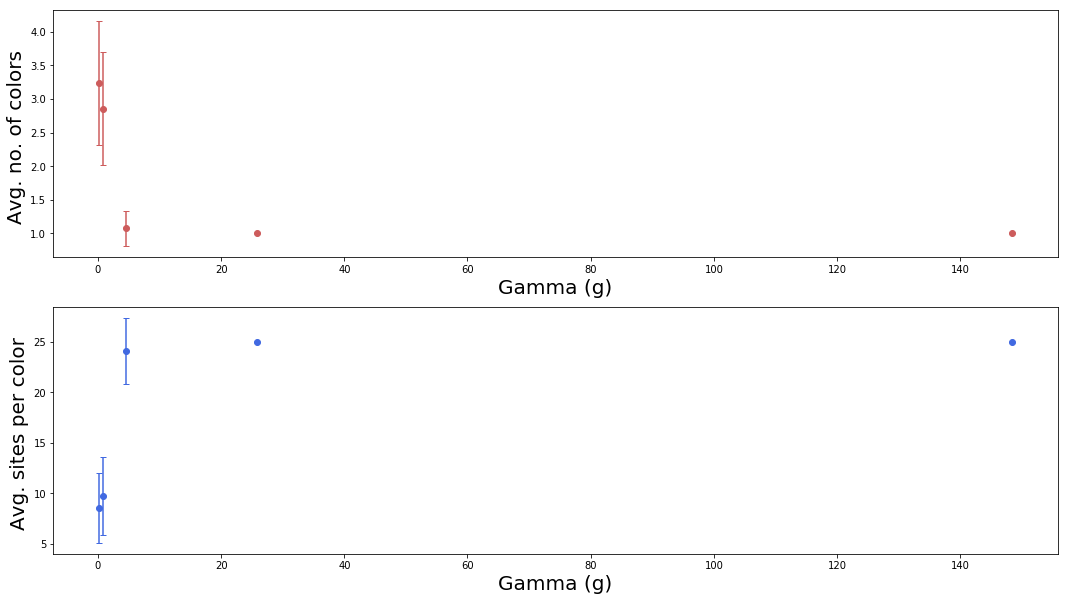

In [144]:
prt = False
experiment_full_interaction_gamma (5, 5, gammas, J=0.4, alpha=0.5)

edge probabilities: [0.55956835 0.44043165]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.13533528]
Trying gammas: [0.14 0.21 0.33 0.51 0.8  1.25 1.95 3.04 4.74 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.57120906]
Initial configuration
[[2 4 4 2 5]
 [1 5 5 2 4]
 [5 3 3 1 3]
 [4 1 1 1 4]
 [5 1 2 2 3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 2.8415841584158414 avg. sites per col: 10.841584158415841
201 num. cols: 3.0199004975124377 avg. sites per col: 9.830016583747911
301 num. cols: 3.0 avg. sites per col: 9.717607973421934
401 num. cols: 3.0 avg. sites per col: 9.660224438902763
501 num. cols: 3.1117764471057883 avg. sites per col: 9.245675316034598
601 num. cols: 3.0831946755407653 avg. sites per col: 9.296311702717674
701 num. cols: 3.0171184022824535 av

equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 2.128712871287129 avg. sites per col: 14.026402640264024
201 num. cols: 1.8656716417910448 avg. sites per col: 16.635572139303495
301 num. cols: 1.9933554817275747 avg. sites per col: 15.323920265780734
401 num. cols: 1.8503740648379052 avg. sites per col: 16.42768079800499
501 num. cols: 1.7904191616766467 avg. sites per col: 16.932801064537596
601 num. cols: 1.7803660565723793 avg. sites per col: 16.94051580698837
701 num. cols: 1.7417974322396577 avg. sites per col: 17.266999524488842
801 num. cols: 1.7215980024968789 avg. sites per col: 17.506762380357912
901 num. cols: 1.6981132075471699 avg. sites per col: 17.769607843137283
1001 num. cols: 1.7532467532467533 avg. sites per col: 17.236929736929746
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.

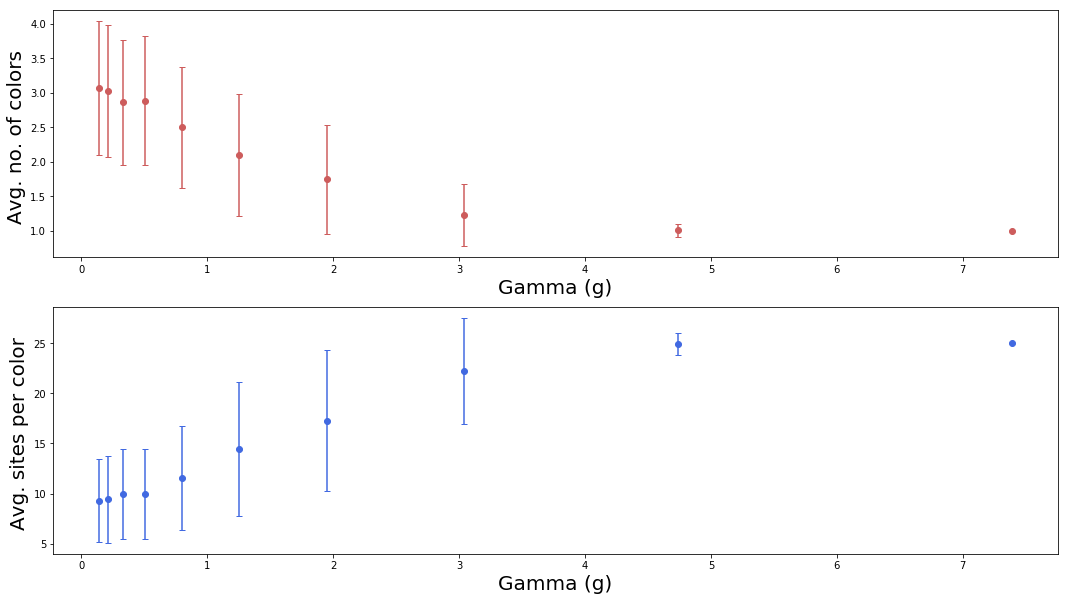

In [146]:
ngamma = 10
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (5, 5, gammas, J=0.41, alpha=0.5)

In [159]:
ngamma = 10
gammas = np.logspace(-2,2, base=np.e, num=ngamma).round(decimals=2)
experiment_full_interaction_gamma (8, 8, gammas, J=0.4, alpha=0.5)

edge probabilities: [0.55067104 0.44932896]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.05325028 0.03229793
 0.01958968 0.03019738]
Trying gammas: [0.14 0.21 0.33 0.51 0.8  1.25 1.95 3.04 4.74 7.39]
0  - gamma: 0.14
lambda probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.07462376 0.06487478
 0.05639942 0.3753111 ]
Initial configuration
[[4 2 7 2 3 4 1 5]
 [2 8 7 1 4 4 2 6]
 [5 2 8 4 6 3 7 2]
 [6 6 8 4 7 2 2 7]
 [7 8 4 1 2 3 5 3]
 [6 5 6 1 8 4 5 5]
 [4 7 1 6 7 3 6 2]
 [2 8 1 1 1 1 5 1]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 3.0 avg. sites per col: 21.333333333333332
101 num. cols: 4.782178217821782 avg. sites per col: 13.927015558698715
201 num. cols: 4.91542288557214 avg. sites per col: 13.669936034115148
301 num. cols: 4.913621262458472 avg. sites per col: 13.718841955386836
401 num. cols: 4.860349127182045 avg. sites per col: 13

equilibration step: 1000


KeyboardInterrupt: 

edge probabilities: [0.55067104 0.44932896]
lambda probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.13533528]
Trying alphas: [0.14 0.21 0.33 0.51 0.8  1.25 1.95 3.04 4.74 7.39]
0  - alpha: 0.14
site probabilities: [0.13064176 0.11357449 0.09873692 0.08583776 0.57120906]
Initial configuration
[[4 2 5 3 4]
 [4 2 3 1 1]
 [3 4 3 4 4]
 [3 2 1 4 4]
 [5 5 1 1 5]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 4.425742574257426 avg. sites per col: 5.895214521452145
201 num. cols: 4.507462686567164 avg. sites per col: 5.717247097844113
301 num. cols: 4.504983388704319 avg. sites per col: 5.729512735326686
401 num. cols: 4.496259351620948 avg. sites per col: 5.733582709891934
501 num. cols: 4.516966067864272 avg. sites per col: 5.69028609447771
601 num. cols: 4.545757071547421 avg. sites per col: 5.645452024403771
701 num. cols: 

1001 num. cols: 1.5394605394605394 avg. sites per col: 18.73126873126873
Final configuration:
[[1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]
 [1 1 1 1 1]]
Final averages: 1.5393034825870646 18.73134328358209
Final stds: 0.6015713358176433 6.557498918002388
------------------------------------------------------------------------------------------------------------------------

6  - alpha: 1.95
site probabilities: [8.57725928e-01 1.22032160e-01 1.73620123e-02 2.47016418e-03
 4.09734979e-04]
Initial configuration
[[2 4 5 2 5]
 [1 5 4 4 4]
 [4 1 1 4 5]
 [1 4 4 2 2]
 [3 3 5 2 3]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 2.0 avg. sites per col: 12.5
101 num. cols: 1.198019801980198 avg. sites per col: 22.524752475247524
201 num. cols: 1.1592039800995024 avg. sites per col: 23.00995024875622
301 num. cols: 1.1362126245847175 avg. sites per col: 23.29734219269103
401 num.

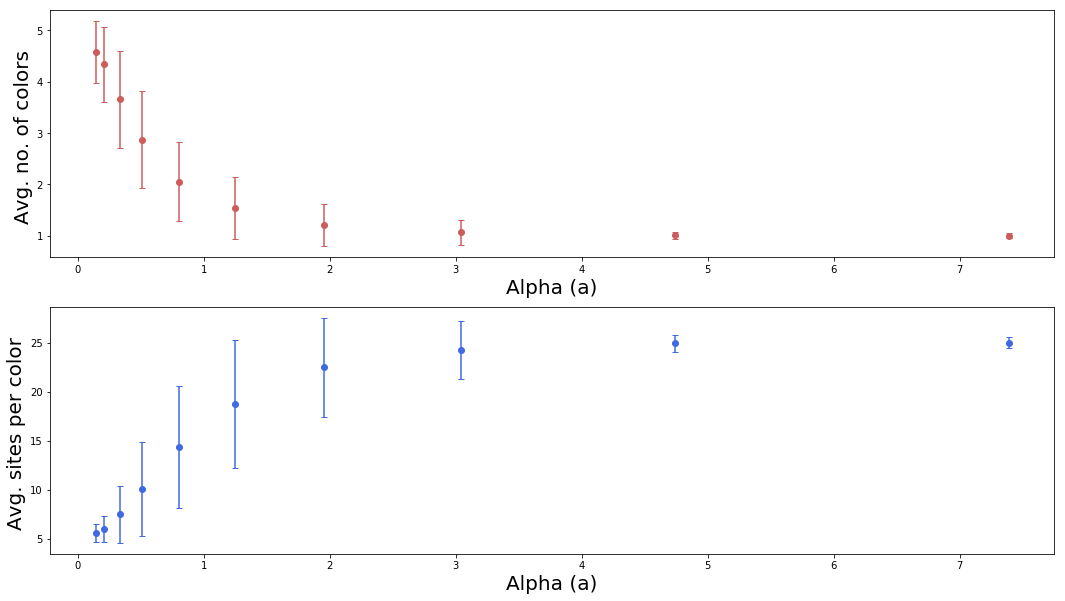

In [158]:
nalpha = 10
alphas = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_alpha (5, 5, alphas, J=0.4, gamma=0.5)

In [ ]:
nJ = 10
Js = np.logspace(-2,2, base=np.e, num=nalpha).round(decimals=2)
experiment_full_interaction_J (5, 5, Js, alpha=0.5, gamma=0.5)

lambda probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.13533528]
site probabilities: [0.39346934 0.23865122 0.14474928 0.08779488 0.13533528]
Trying Js: [0.14 0.21 0.33 0.51 0.8  1.25 1.95 3.04 4.74 7.39]
0  - J: 0.14
edge probabilities: [0.24421626 0.75578374]
Initial configuration
[[5 5 1 4 4]
 [3 3 5 1 4]
 [5 1 5 1 1]
 [1 4 5 4 1]
 [5 2 1 4 2]]
equilibration step: 0
equilibration step: 1000
equilibration step: 2000
equilibration step: 3000
equilibration step: 4000
equilibration step: 5000
1 num. cols: 5.0 avg. sites per col: 5.0
101 num. cols: 4.415841584158416 avg. sites per col: 5.746699669966996
201 num. cols: 4.268656716417911 avg. sites per col: 6.013681592039803
301 num. cols: 4.235880398671096 avg. sites per col: 6.07142857142857
401 num. cols: 4.216957605985037 avg. sites per col: 6.12219451371571
501 num. cols: 4.259481037924152 avg. sites per col: 6.055389221556889
601 num. cols: 4.27287853577371 avg. sites per col: 6.040626733222414
701 num. cols: 4.26105563